<a href="https://colab.research.google.com/github/priyadharshini13/oxford_ml_project/blob/main/Group3_AI_ML%20Application_DemandPrediction_Jun16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Executive Summary:

Purpose and Business Objective:

    Aim: Streamline operations, reduce excess costs, enhance customer satisfaction.
    Implementation: Developed predictive model using SARIMA (Tried ARIMA, Prophet as well) for demand forecasting.

Business View:

Business Case:

    Excess inventory reduction by 30%: Predictive models implemented to optimize inventory.
    Market analysis and cost-benefit analysis: Not explicitly covered in code, but implied through the project's objective.

Stakeholder Analysis:

    Inventory Managers: Predictive insights for accurate stock management.
    Financial Officers: Outputs to optimize budget allocations.
    Logistics Coordinators: Actionable recommendations for streamlining processes.
    Implementation: Forecasting models provide predictive insights for stakeholders.

ROI and Success Metrics:

Metrics:

    Reduction in overstock levels.
    Decreased storage and handling costs.
    Improvement in inventory turnover ratio.
    Increased cash flow and reduced operational expenses.
    Implementation: Metrics can be derived from the forecasting model's output.

Project Overview:

Scope:

    Data collection and preprocessing.
    Model training, testing, and deployment.
    Implementation: Covered through data preprocessing, EDA, model development, and initial validation.


User Stories:

User Story 1: Dynamic Inventory Adjustment Based on Sales Forecast

    Acceptance Criteria: Automatic adjustment of inventory orders, notifications for significant changes.
    Implementation: Automated inventory adjustments and notifications based on forecasts.

User Story 2: Inventory Analytics and Reporting

    Acceptance Criteria: Comprehensive reports on inventory metrics, real-time accessibility, alerts for issues.
    Implementation: Developed reporting tools and visualizations for inventory metrics.

User Story 3: Demand Forecast Visualization

    Acceptance Criteria: Visualizations of demand forecasts, comparison with historical data.
    Implementation: Enhanced visualization tools for demand forecasts.


# Implementation of Demand Prediction Model - using ML

The main steps involve data preprocessing, exploratory data analysis (EDA), model development, and validation. Here's a detailed breakdown of the steps along with the Python code implementation.

In [1]:
# Install necessary packages
!pip install prophet
!pip install scikit-learn
!pip install behave


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.8/136.8 kB 7.7 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import itertools
from google.colab import files
import io
from sklearn.model_selection import TimeSeriesSplit
import unittest
import seaborn as sns
import time



# 1. Data Collection and Pre-processing


1.  Load the dataset
2.  Clean the data: Handle missing values, outliers, and convert data types if necessary.
3. Feature engineering: Create additional features like month, year, or quarter from the date to analyze seasonal trends.


In [2]:
# Step 1: Upload the CSV file
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Load the dataset
data = pd.read_csv(io.BytesIO(uploaded[filename]))


Saving synthetic_retail_data_for_demand_prediction.csv to synthetic_retail_data_for_demand_prediction.csv


In [3]:
data.head()

,Date of Sale,Store ID,Country,Product ID,Product Category,Units Sold,Price Sold,GDP Growth Rate,Inflation Rate
0,2000-01-01,4,USA,15,Home & Kitchen,14,229.25,1.716353,1.006865
1,2000-01-02,5,Canada,6,Electronics,21,104.01,1.955608,2.417040
2,2000-01-03,3,Canada,11,Electronics,16,169.17,1.774069,2.509185
3,2000-01-04,5,USA,8,Books,19,179.60,2.112682,2.636036
4,2000-01-05,5,Mexico,17,Books,24,286.81,1.943792,1.945556


In [4]:
# Printing summary statistics of the data
summary_stats = data.describe()
summary_stats.head()

,Store ID,Product ID,Units Sold,Price Sold,GDP Growth Rate,Inflation Rate
count,8918.000000,8918.000000,8918.000000,8918.000000,8918.000000,8918.000000
mean,2.996187,10.538125,21.305786,257.798725,1.996123,1.993854
std,1.419827,5.762763,5.382458,141.548303,0.502141,0.500699
min,1.000000,1.000000,6.000000,10.060000,0.197802,0.111380
25%,2.000000,6.000000,18.000000,135.472500,1.659930,1.658651


In [5]:
# Printing summary statistics of Categorical data
summary_stats_categorical = data.describe(include='O')
summary_stats_categorical.head()

,Date of Sale,Country,Product Category
count,8918,8918,8918
unique,8918,3,5
top,2000-01-01,USA,Books
freq,1,3005,1915


In [6]:
# Step 2: Handle Missing Values
# Check for any missing values and handle them appropriately. In this synthetic dataset, missing values are unlikely, but it's a good practice to check.

missing_values = data.isnull().sum()
print('Missing Values: ')
print('---------------')
print(missing_values)


Missing Values: 
---------------
Date of Sale        0
Store ID            0
Country             0
Product ID          0
Product Category    0
Units Sold          0
Price Sold          0
GDP Growth Rate     0
Inflation Rate      0
dtype: int64


There are no missing values in any of the columns.

In [ ]:
# If there are missing values, handle them (here we assume no missing values for simplicity)
# df.fillna(method='ffill', inplace=True)

# 2. Exploratory Data analysis


In [7]:
# Convert 'Date of Sale' to datetime
data['Date of Sale'] = pd.to_datetime(data['Date of Sale'])

# Set 'Date of Sale' as the index
data.set_index('Date of Sale', inplace=True)

# Display the first few rows of the dataset
print(data.head())

              Store ID Country  Product ID Product Category  Units Sold  \
Date of Sale                                                              
2000-01-01           4     USA          15   Home & Kitchen          14   
2000-01-02           5  Canada           6      Electronics          21   
2000-01-03           3  Canada          11      Electronics          16   
2000-01-04           5     USA           8            Books          19   
2000-01-05           5  Mexico          17            Books          24   

              Price Sold  GDP Growth Rate  Inflation Rate  
Date of Sale                                               
2000-01-01        229.25         1.716353        1.006865  
2000-01-02        104.01         1.955608        2.417040  
2000-01-03        169.17         1.774069        2.509185  
2000-01-04        179.60         2.112682        2.636036  
2000-01-05        286.81         1.943792        1.945556  



The following exploratory data analysis are performed below:

1. **Total Units Sold Over Time:** Plots the trend of units sold over time.

2. **Units Sold vs. Economic Indicators:** Analyzes the relationship between units sold and GDP growth rate/inflation rate.
3. **Units Sold by Product Category:** Visualizes total units sold by product categories.
4. **Correlation Matrix:** Calculates and visualizes the correlation matrix for numerical features only.
5. **Seasonal Decomposition:** Decomposes the time series data to analyze trend, seasonality, and residuals.
6. **Boxplots for Outliers:** Checks for outliers in numerical features using boxplots.




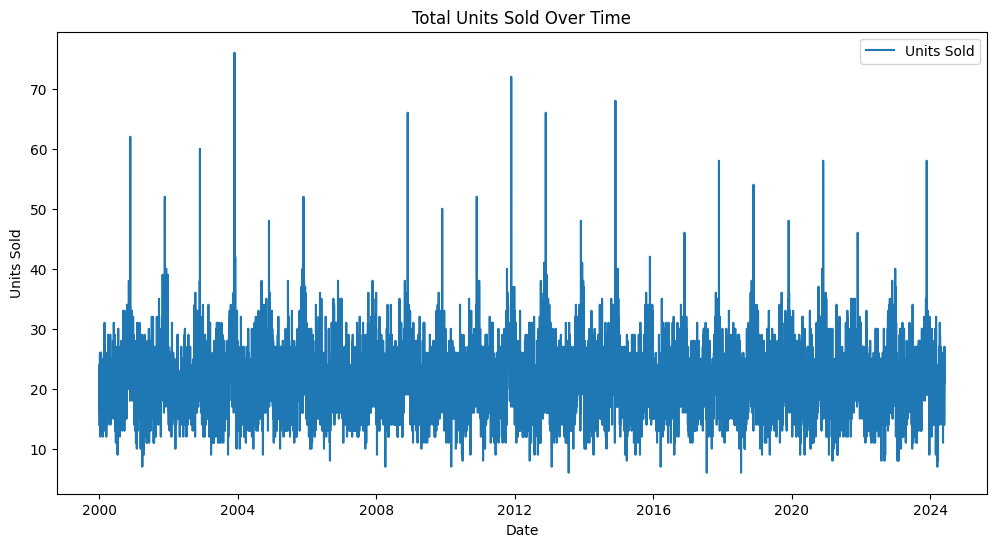

In [34]:
# @title  1) Total Units Sold Over Time

#  Visualize the trend of units sold over time to identify any seasonal patterns or trends.
# Plot the total units sold over time
plt.figure(figsize=(12, 6))
plt.plot(data['Units Sold'], label='Units Sold')
plt.title('Total Units Sold Over Time')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.show()


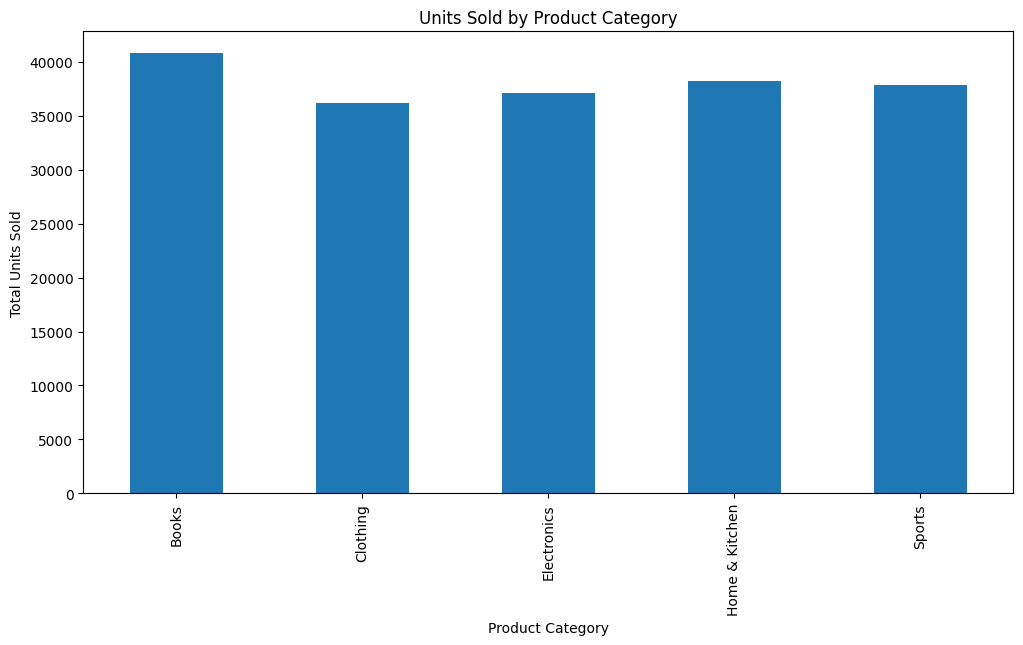

In [35]:
# @title 2. Bar plot of Units Sold by Product Category
# Visualize the total units sold by different product categories.

plt.figure(figsize=(12, 6))
data.groupby('Product Category')['Units Sold'].sum().plot(kind='bar')
plt.title('Units Sold by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Total Units Sold')
plt.show()


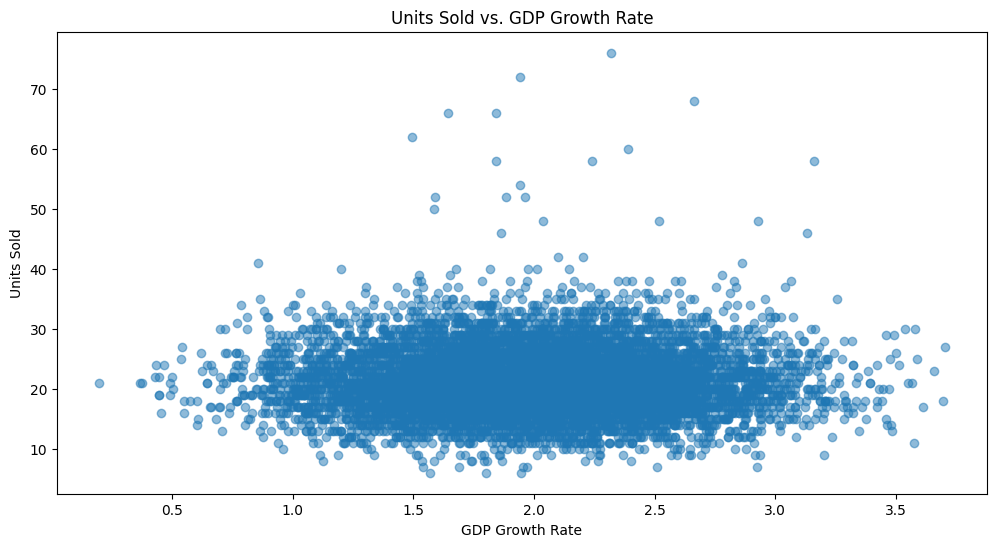

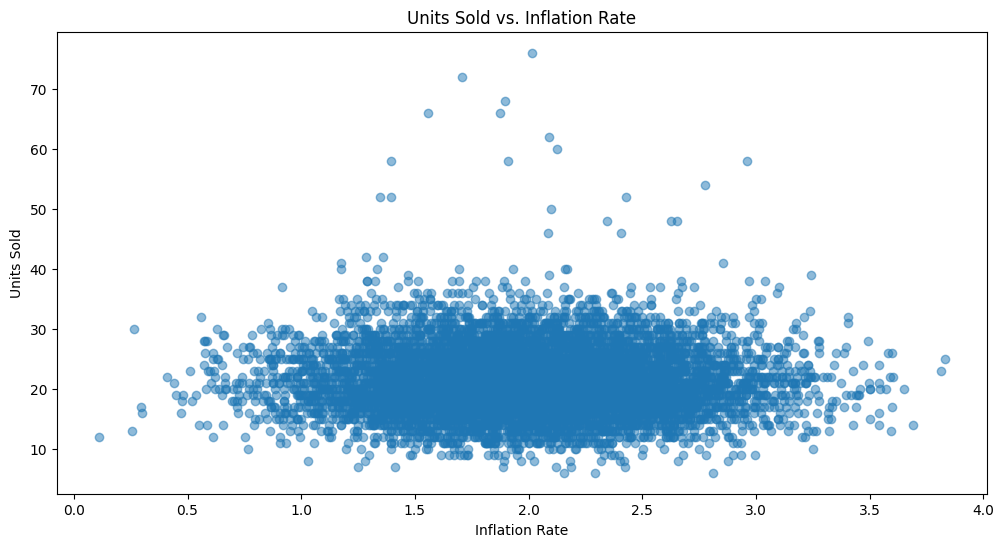

In [38]:
# @title 3. Units Sold vs. Economic Indicators
# Analyze the relationship between units sold and economic indicators like GDP growth rate and inflation rate.

plt.figure(figsize=(12, 6))
plt.scatter(data['GDP Growth Rate'], data['Units Sold'], alpha=0.5)
plt.title('Units Sold vs. GDP Growth Rate')
plt.xlabel('GDP Growth Rate')
plt.ylabel('Units Sold')
plt.show()

# Scatter plot of Units Sold vs. Inflation Rate
plt.figure(figsize=(12, 6))
plt.scatter(data['Inflation Rate'], data['Units Sold'], alpha=0.5)
plt.title('Units Sold vs. Inflation Rate')
plt.xlabel('Inflation Rate')
plt.ylabel('Units Sold')
plt.show()


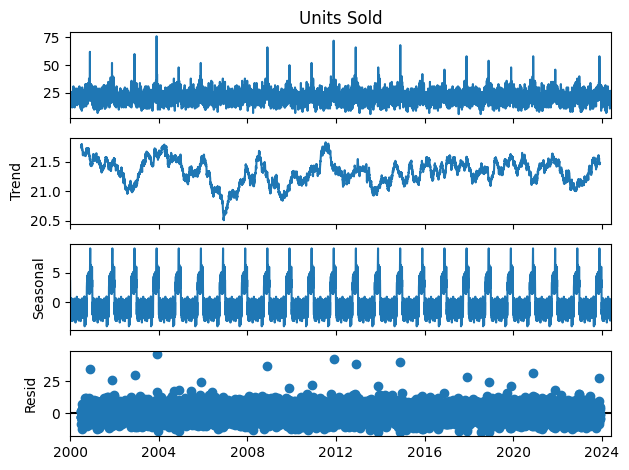

In [40]:
# @title 4. Seasonal decomposition of the time series
# Perform seasonal decomposition to analyze the trend, seasonality, and residuals in the time series data.

result = seasonal_decompose(data['Units Sold'], model='additive', period=365)
result.plot()
plt.show()


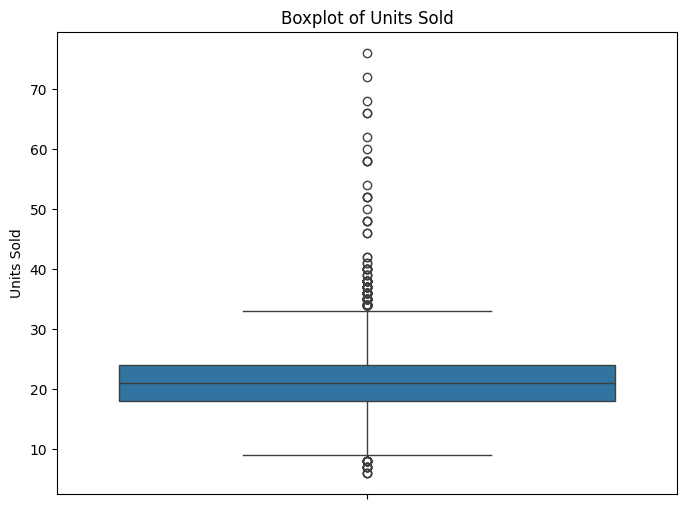

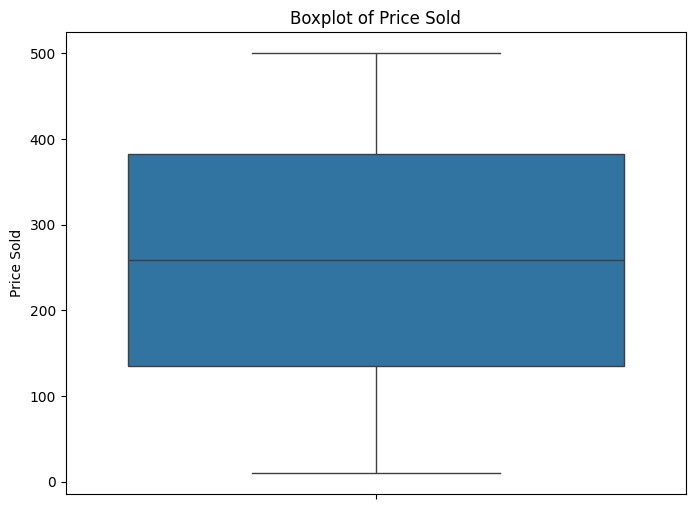

In [42]:
# @title 5. Boxplot for Units Sold
# Check for outliers in numerical features using boxplots.

plt.figure(figsize=(8, 6))
sns.boxplot(data['Units Sold'])
plt.title('Boxplot of Units Sold')
plt.show()

# Boxplot for Price Sold
plt.figure(figsize=(8, 6))
sns.boxplot(data['Price Sold'])
plt.title('Boxplot of Price Sold')
plt.show()


Correlation Matrix:
                  Units Sold  Price Sold  GDP Growth Rate  Inflation Rate
Units Sold         1.000000    0.012150         0.004119       -0.011851
Price Sold         0.012150    1.000000        -0.013537        0.002616
GDP Growth Rate    0.004119   -0.013537         1.000000        0.007377
Inflation Rate    -0.011851    0.002616         0.007377        1.000000


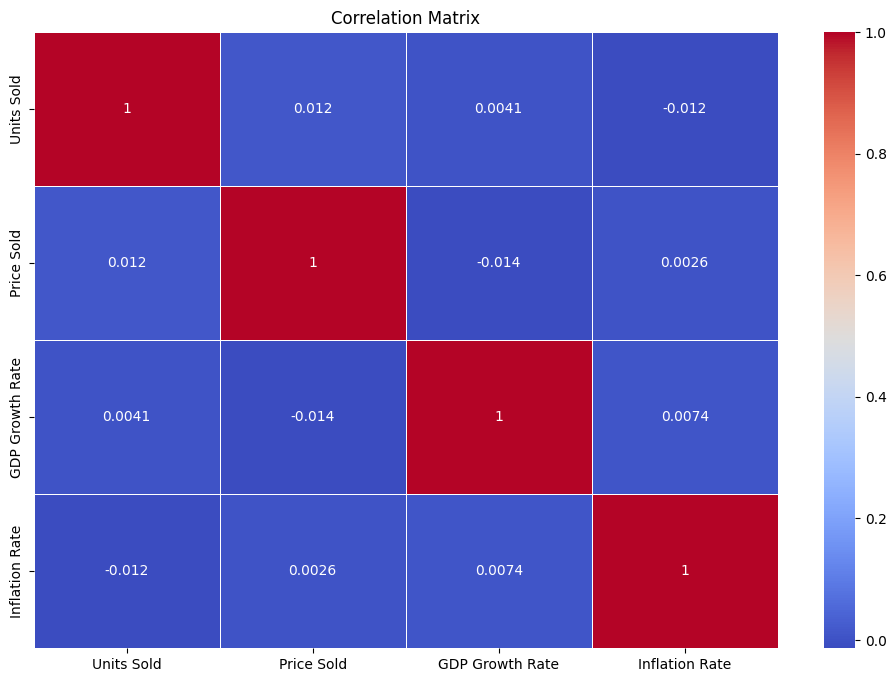

In [50]:
# @title 6. Correlation
# Calculate and visualize the correlation matrix to understand relationships between different features. Only include numerical columns for this calculation.

#  Select only numerical columns for correlation matrix
numerical_columns = ['Units Sold', 'Price Sold', 'GDP Growth Rate', 'Inflation Rate']

# Calculate the correlation matrix
correlation_matrix = data[numerical_columns].corr()

# Display the correlation matrix
print("Correlation Matrix:\n", correlation_matrix)

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
plt.title('Correlation Matrix')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()


# 3: Feature Engineering


In [3]:
# Step 1: Upload the CSV file
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Load the dataset
data = pd.read_csv(io.BytesIO(uploaded[filename]))


Saving synthetic_retail_data_for_demand_prediction.csv to synthetic_retail_data_for_demand_prediction (2).csv


In [23]:
data.head()

,Store ID,Country,Product ID,Product Category,Units Sold,Price Sold,GDP Growth Rate,Inflation Rate,Year,Month,Day,DayOfWeek,Quarter
0,4,USA,15,Home & Kitchen,14,229.25,1.716353,1.006865,2000,1,1,5,1
1,5,Canada,6,Electronics,21,104.01,1.955608,2.417040,2000,1,2,6,1
2,3,Canada,11,Electronics,16,169.17,1.774069,2.509185,2000,1,3,0,1
3,5,USA,8,Books,19,179.60,2.112682,2.636036,2000,1,4,1,1
4,5,Mexico,17,Books,24,286.81,1.943792,1.945556,2000,1,5,2,1


In [4]:
# @title Step 1 -  Extract useful information from the date and transform categorical variables.
# Feature Engineering

# Convert 'Date of Sale' to datetime
data['Date of Sale'] = pd.to_datetime(data['Date of Sale'])

# Extract additional features from 'Date of Sale'
data['Year'] = data['Date of Sale'].dt.year
data['Month'] = data['Date of Sale'].dt.month
data['Day'] = data['Date of Sale'].dt.day
data['DayOfWeek'] = data['Date of Sale'].dt.dayofweek
data['Quarter'] = data['Date of Sale'].dt.quarter

# Drop the original 'Date of Sale' column
data.drop(columns=['Date of Sale'], inplace=True)


In [5]:
# @title Step 2 - Encode Categorical Variables

# Convert categorical variables into numerical representations using one-hot encoding.

# List of categorical features
categorical_features = ['Store ID', 'Country', 'Product ID', 'Product Category']

# One-hot encode categorical features
df = pd.get_dummies(data, columns=categorical_features, drop_first=True)

# Display the first few rows of the transformed dataset
print(df.head())


   Units Sold  Price Sold  GDP Growth Rate  Inflation Rate  Year  Month  Day  \
0          14      229.25         1.716353        1.006865  2000      1    1   
1          21      104.01         1.955608        2.417040  2000      1    2   
2          16      169.17         1.774069        2.509185  2000      1    3   
3          19      179.60         2.112682        2.636036  2000      1    4   
4          24      286.81         1.943792        1.945556  2000      1    5   

   DayOfWeek  Quarter  Store ID_2  ...  Product ID_15  Product ID_16  \
0          5        1       False  ...           True          False   
1          6        1       False  ...          False          False   
2          0        1       False  ...          False          False   
3          1        1       False  ...          False          False   
4          2        1       False  ...          False          False   

   Product ID_17  Product ID_18  Product ID_19  Product ID_20  \
0          False     

# Normalize Numerical Features

In [6]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

In [7]:
# @title Step 3 - Normalize Numerical Features
# Standardize numerical features to have a mean of 0 and a standard deviation of 1.

# List of numerical features
numerical_features = ['Units Sold', 'Price Sold', 'GDP Growth Rate', 'Inflation Rate', 'Year', 'Month', 'Day', 'DayOfWeek', 'Quarter']

# Standardize numerical features
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Display the first few rows of the transformed dataset
print(df.head())


   Units Sold  Price Sold  GDP Growth Rate  Inflation Rate     Year     Month  \
0   -1.357409   -0.201700        -0.557185       -1.971333 -1.66101 -1.581491   
1   -0.056815   -1.086536        -0.080688        0.845239 -1.66101 -1.581491   
2   -0.985810   -0.626173        -0.442238        1.029281 -1.66101 -1.581491   
3   -0.428413   -0.552484         0.232137        1.282643 -1.66101 -1.581491   
4    0.500583    0.204968        -0.104220       -0.096467 -1.66101 -1.581491   

        Day  DayOfWeek   Quarter  Store ID_2  ...  Product ID_15  \
0 -1.673804        1.0 -1.331754       False  ...           True   
1 -1.560166        1.5 -1.331754       False  ...          False   
2 -1.446529       -1.5 -1.331754       False  ...          False   
3 -1.332891       -1.0 -1.331754       False  ...          False   
4 -1.219254       -0.5 -1.331754       False  ...          False   

   Product ID_16  Product ID_17  Product ID_18  Product ID_19  Product ID_20  \
0          False        

In [8]:
df.head()

,Units Sold,Price Sold,GDP Growth Rate,Inflation Rate,Year,Month,Day,DayOfWeek,Quarter,Store ID_2,...,Product ID_15,Product ID_16,Product ID_17,Product ID_18,Product ID_19,Product ID_20,Product Category_Clothing,Product Category_Electronics,Product Category_Home & Kitchen,Product Category_Sports
0,-1.357409,-0.201700,-0.557185,-1.971333,-1.66101,-1.581491,-1.673804,1.0,-1.331754,False,...,True,False,False,False,False,False,False,False,True,False
1,-0.056815,-1.086536,-0.080688,0.845239,-1.66101,-1.581491,-1.560166,1.5,-1.331754,False,...,False,False,False,False,False,False,False,True,False,False
2,-0.985810,-0.626173,-0.442238,1.029281,-1.66101,-1.581491,-1.446529,-1.5,-1.331754,False,...,False,False,False,False,False,False,False,True,False,False
3,-0.428413,-0.552484,0.232137,1.282643,-1.66101,-1.581491,-1.332891,-1.0,-1.331754,False,...,False,False,False,False,False,False,False,False,False,False
4,0.500583,0.204968,-0.104220,-0.096467,-1.66101,-1.581491,-1.219254,-0.5,-1.331754,False,...,False,False,True,False,False,False,False,False,False,False


In [9]:
numerical_features = ['Units Sold', 'Price Sold', 'GDP Growth Rate', 'Inflation Rate', 'Year', 'Month', 'Day', 'DayOfWeek', 'Quarter']
data_to_test_and_train = df[numerical_features]
data_to_test_and_train.head()

,Units Sold,Price Sold,GDP Growth Rate,Inflation Rate,Year,Month,Day,DayOfWeek,Quarter
0,-1.357409,-0.201700,-0.557185,-1.971333,-1.66101,-1.581491,-1.673804,1.0,-1.331754
1,-0.056815,-1.086536,-0.080688,0.845239,-1.66101,-1.581491,-1.560166,1.5,-1.331754
2,-0.985810,-0.626173,-0.442238,1.029281,-1.66101,-1.581491,-1.446529,-1.5,-1.331754
3,-0.428413,-0.552484,0.232137,1.282643,-1.66101,-1.581491,-1.332891,-1.0,-1.331754
4,0.500583,0.204968,-0.104220,-0.096467,-1.66101,-1.581491,-1.219254,-0.5,-1.331754


In [10]:
# @title Step 4: Split Data into Training and Testing Sets

# Select the 'Units Sold' column for time series analysis
ts_data = data_to_test_and_train[['Units Sold']]  # Ensure it is a DataFrame with a single column

# Split the data into training and testing sets
# For time series data, it is common to split the data based on time. We'll use the first 80% of the data for training and the remaining 20% for testing.

split_point = int(len(ts_data) * 0.8)
train_data, test_data = ts_data[:split_point], ts_data[split_point:]

# Ensure the data is numeric
train_data = train_data.astype(float)
test_data = test_data.astype(float)

print(f"Training data: {len(train_data)} records")
print(f"Testing data: {len(test_data)} records")

# Define the SARIMA model
sarima_model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)


Training data: 7134 records
Testing data: 1784 records


Fit the SARIMA Model: Fit the SARIMA model to the 'Units Sold' time series data and evaluate its performance.

In [11]:
# @title Step 5: Fit the SARIMA Model

# Fit the model
sarima_results = sarima_model.fit(disp=False)

# Print model summary
print(sarima_results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                         Units Sold   No. Observations:                 7134
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -9725.509
Date:                            Sun, 16 Jun 2024   AIC                          19461.019
Time:                                    07:53:49   BIC                          19495.363
Sample:                                         0   HQIC                         19472.844
                                           - 7134                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0044      0.012     -0.359      0.720      -0.029       0.020
ma.L1         -0.9190      0.005   

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [13]:
# Make predictions
train_pred = sarima_results.predict(start=train_data.index[0], end=train_data.index[-1], dynamic=False)
test_pred = sarima_results.get_forecast(steps=len(test_data))
test_pred_mean = test_pred.predicted_mean
test_pred_conf = test_pred.conf_int()

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(train_data, train_pred))
train_mae = mean_absolute_error(train_data, train_pred)
train_r2 = r2_score(train_data, train_pred)

test_rmse = np.sqrt(mean_squared_error(test_data, test_pred_mean))
test_mae = mean_absolute_error(test_data, test_pred_mean)
test_r2 = r2_score(test_data, test_pred_mean)

print(f"Training RMSE: {train_rmse}, Training MAE: {train_mae}, Training R2: {train_r2}")
print(f"Testing RMSE: {test_rmse}, Testing MAE: {test_mae}, Testing R2: {test_r2}")

Training RMSE: 0.950890117889699, Training MAE: 0.7286040247431225, Training R2: 0.10414866619433405
Testing RMSE: 0.9819585488850662, Testing MAE: 0.7603764759552577, Testing R2: -0.001829109613167068


In [31]:
# Check the correlation between 'Units Sold' and economic indicators
correlation_matrix = data_to_test_and_train[['Units Sold', 'GDP Growth Rate', 'Inflation Rate', 'Price Sold']].corr()
print(correlation_matrix)

                 Units Sold  GDP Growth Rate  Inflation Rate  Price Sold
Units Sold         1.000000         0.004119       -0.011851    0.012150
GDP Growth Rate    0.004119         1.000000        0.007377   -0.013537
Inflation Rate    -0.011851         0.007377        1.000000    0.002616
Price Sold         0.012150        -0.013537        0.002616    1.000000


In [14]:
# Predict future sales using SARIMA
# forecast_steps = 12
# Define the forecast period
forecast_steps = (2030 - 2024) * 12  # 6 years * 12 months
# Make predictions
forecast = sarima_results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start='2024-05-01', periods=forecast_steps, freq='M')
predicted_means = forecast.predicted_mean
predicted_conf = forecast.conf_int()

# Ensure forecast index matches predicted means
predicted_means.index = forecast_index
predicted_conf.index = forecast_index
# -----

# sarima_forecast = sarima_results.get_forecast(steps=forecast_steps)
# predicted_means = sarima_forecast.predicted_mean

# # Plot SARIMA forecast
# plt.figure(figsize=(12, 6))
# plt.plot(train_data.index, train_data, label='Observed')
# plt.plot(pd.date_range(start=train_data.index[-1], periods=forecast_steps+1, freq='M')[1:], predicted_means, label='Forecast', color='red')
# plt.fill_between(predicted_means.index, sarima_forecast.conf_int().iloc[:, 0],
#                  sarima_forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)
# plt.title('SARIMA Forecast')
# plt.xlabel('Date')
# plt.ylabel('Units Sold')
# plt.legend()
# plt.show()

# # Seasonal Decomposition
# result = seasonal_decompose(train_data, model='additive', period=12)
# result.plot()
plt.show()

In [24]:
train_data.head()

,Units Sold
0,-1.357409
1,-0.056815
2,-0.985810
3,-0.428413
4,0.500583


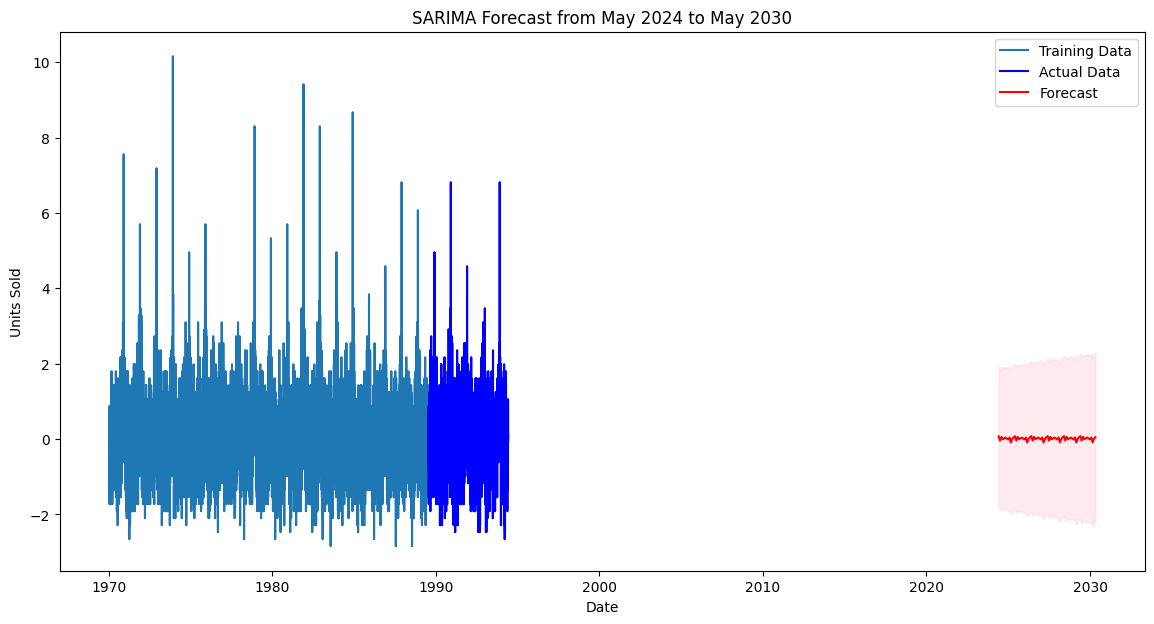

In [15]:
# Plot the actual data and forecast
plt.figure(figsize=(14, 7))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual Data', color='blue')
plt.plot(predicted_means, label='Forecast', color='red')
plt.fill_between(predicted_conf.index, predicted_conf.iloc[:, 0], predicted_conf.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Year')
plt.ylabel('Units Sold')
plt.title('SARIMA Forecast from May 2024 to May 2030')
plt.legend()
plt.show()


In [26]:
predicted_means.head()

2024-05-31    0.072841
2024-06-30   -0.042981
2024-07-31    0.056160
2024-08-31   -0.005456
2024-09-30    0.017062
Freq: M, Name: predicted_mean, dtype: float64

In [27]:
forecast_index

DatetimeIndex(['2024-05-31', '2024-06-30', '2024-07-31', '2024-08-31',
               '2024-09-30', '2024-10-31', '2024-11-30', '2024-12-31',
               '2025-01-31', '2025-02-28', '2025-03-31', '2025-04-30',
               '2025-05-31', '2025-06-30', '2025-07-31', '2025-08-31',
               '2025-09-30', '2025-10-31', '2025-11-30', '2025-12-31',
               '2026-01-31', '2026-02-28', '2026-03-31', '2026-04-30',
               '2026-05-31', '2026-06-30', '2026-07-31', '2026-08-31',
               '2026-09-30', '2026-10-31', '2026-11-30', '2026-12-31',
               '2027-01-31', '2027-02-28', '2027-03-31', '2027-04-30',
               '2027-05-31', '2027-06-30', '2027-07-31', '2027-08-31',
               '2027-09-30', '2027-10-31', '2027-11-30', '2027-12-31',
               '2028-01-31', '2028-02-29', '2028-03-31', '2028-04-30',
               '2028-05-31', '2028-06-30', '2028-07-31', '2028-08-31',
               '2028-09-30', '2028-10-31', '2028-11-30', '2028-12-31',
      

In [28]:
sarima_results

In [29]:
data.head()

,Store ID,Country,Product ID,Product Category,Units Sold,Price Sold,GDP Growth Rate,Inflation Rate,Year,Month,Day,DayOfWeek,Quarter
0,4,USA,15,Home & Kitchen,14,229.25,1.716353,1.006865,2000,1,1,5,1
1,5,Canada,6,Electronics,21,104.01,1.955608,2.417040,2000,1,2,6,1
2,3,Canada,11,Electronics,16,169.17,1.774069,2.509185,2000,1,3,0,1
3,5,USA,8,Books,19,179.60,2.112682,2.636036,2000,1,4,1,1
4,5,Mexico,17,Books,24,286.81,1.943792,1.945556,2000,1,5,2,1


In [30]:
# Step 1: Upload the CSV file
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Load the dataset
data_new = pd.read_csv(io.BytesIO(uploaded[filename]))


Saving synthetic_retail_data_for_demand_prediction.csv to synthetic_retail_data_for_demand_prediction (3).csv


In [31]:
data_new.head()

,Date of Sale,Store ID,Country,Product ID,Product Category,Units Sold,Price Sold,GDP Growth Rate,Inflation Rate
0,2000-01-01,4,USA,15,Home & Kitchen,14,229.25,1.716353,1.006865
1,2000-01-02,5,Canada,6,Electronics,21,104.01,1.955608,2.417040
2,2000-01-03,3,Canada,11,Electronics,16,169.17,1.774069,2.509185
3,2000-01-04,5,USA,8,Books,19,179.60,2.112682,2.636036
4,2000-01-05,5,Mexico,17,Books,24,286.81,1.943792,1.945556


In [33]:


# Convert 'Date of Sale' to datetime
df['Date of Sale'] = pd.to_datetime(data_new['Date of Sale'])

# Set 'Date of Sale' as the index
df.set_index('Date of Sale', inplace=True)

# Ensure all relevant columns are numeric
numeric_columns = ['Units Sold', 'Price Sold', 'GDP Growth Rate', 'Inflation Rate']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Check for and handle missing values
df = data_new.dropna()

# Verify the start date of the dataset
print(df.index.min(), df.index.max())

# Select the 'Units Sold' column for time series analysis
ts_data = df['Units Sold']


0 8917


In [42]:
df.head()

,Date of Sale,Store ID,Country,Product ID,Product Category,Units Sold,Price Sold,GDP Growth Rate,Inflation Rate
0,2000-01-01,4,USA,15,Home & Kitchen,14,229.25,1.716353,1.006865
1,2000-01-02,5,Canada,6,Electronics,21,104.01,1.955608,2.417040
2,2000-01-03,3,Canada,11,Electronics,16,169.17,1.774069,2.509185
3,2000-01-04,5,USA,8,Books,19,179.60,2.112682,2.636036
4,2000-01-05,5,Mexico,17,Books,24,286.81,1.943792,1.945556


In [43]:
# Set 'Date of Sale' as the index
df.set_index('Date of Sale', inplace=True)


In [34]:
ts_data.head()

0    14
1    21
2    16
3    19
4    24
Name: Units Sold, dtype: int64

In [44]:
df.head()

,Store ID,Country,Product ID,Product Category,Units Sold,Price Sold,GDP Growth Rate,Inflation Rate
Date of Sale,,,,,,,,
2000-01-01,4,USA,15,Home & Kitchen,14,229.25,1.716353,1.006865
2000-01-02,5,Canada,6,Electronics,21,104.01,1.955608,2.417040
2000-01-03,3,Canada,11,Electronics,16,169.17,1.774069,2.509185
2000-01-04,5,USA,8,Books,19,179.60,2.112682,2.636036
2000-01-05,5,Mexico,17,Books,24,286.81,1.943792,1.945556


In [45]:
# Verify the start date of the dataset
print(df.index.min(), df.index.max())

# Select the 'Units Sold' column for time series analysis
ts_data = df['Units Sold']

2000-01-01 2024-05-31


In [46]:
ts_data

Date of Sale
2000-01-01    14
2000-01-02    21
2000-01-03    16
2000-01-04    19
2000-01-05    24
              ..
2024-05-27    14
2024-05-28    20
2024-05-29    27
2024-05-30    21
2024-05-31    22
Name: Units Sold, Length: 8918, dtype: int64

In [47]:
# Define the SARIMA model
sarima_model = SARIMAX(ts_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)

# Fit the model
sarima_results = sarima_model.fit(disp=False)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [48]:
print(sarima_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Units Sold   No. Observations:                 8918
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -27096.897
Date:                            Sun, 16 Jun 2024   AIC                          54203.795
Time:                                    08:18:16   BIC                          54239.259
Sample:                                01-01-2000   HQIC                         54215.870
                                     - 05-31-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0011      0.011      0.104      0.918      -0.021       0.023
ma.L1         -0.9218      0.004   

In [ ]:
# Make predictions
train_pred = sarima_results.predict(start=train_data.index[0], end=train_data.index[-1], dynamic=False)
test_pred = sarima_results.get_forecast(steps=len(test_data))
test_pred_mean = test_pred.predicted_mean
test_pred_conf = test_pred.conf_int()

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(train_data, train_pred))
train_mae = mean_absolute_error(train_data, train_pred)
train_r2 = r2_score(train_data, train_pred)

test_rmse = np.sqrt(mean_squared_error(test_data, test_pred_mean))
test_mae = mean_absolute_error(test_data, test_pred_mean)
test_r2 = r2_score(test_data, test_pred_mean)

print(f"Training RMSE: {train_rmse}, Training MAE: {train_mae}, Training R2: {train_r2}")
print(f"Testing RMSE: {test_rmse}, Testing MAE: {test_mae}, Testing R2: {test_r2}")

In [49]:
# Define the forecast period
forecast_start = '2024-05-01'
forecast_end = '2030-05-01'
forecast_steps = (pd.to_datetime(forecast_end) - pd.to_datetime(forecast_start)).days // 30  # Approximate monthly steps

# Make predictions
forecast = sarima_results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=forecast_start, periods=forecast_steps, freq='M')
predicted_means = forecast.predicted_mean
predicted_conf = forecast.conf_int()

# Ensure forecast index matches predicted means
predicted_means.index = forecast_index
predicted_conf.index = forecast_index


In [51]:
start_date = ts_data.index.min()
print(ts_data.index.min())

2000-01-01


In [52]:
# Define the forecast period
forecast_start = '2024-05-01'
forecast_end = '2030-05-01'
forecast_steps = (pd.to_datetime(forecast_end) - pd.to_datetime(forecast_start)).days // 30  # Approximate monthly steps

# Make predictions
forecast = sarima_results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=forecast_start, periods=forecast_steps, freq='M')
predicted_means = forecast.predicted_mean
predicted_conf = forecast.conf_int()

# Ensure forecast index matches predicted means
predicted_means.index = forecast_index
predicted_conf.index = forecast_index


In [55]:
predicted_means

2024-05-31    20.386675
2024-06-30    19.764224
2024-07-31    20.209707
2024-08-31    20.441199
2024-09-30    20.509844
                ...    
2030-01-31    20.270098
2030-02-28    20.432951
2030-03-31    20.217608
2030-04-30    20.261916
2030-05-31    20.386082
Freq: M, Name: predicted_mean, Length: 73, dtype: float64

In [56]:
predicted_means.index

DatetimeIndex(['2024-05-31', '2024-06-30', '2024-07-31', '2024-08-31',
               '2024-09-30', '2024-10-31', '2024-11-30', '2024-12-31',
               '2025-01-31', '2025-02-28', '2025-03-31', '2025-04-30',
               '2025-05-31', '2025-06-30', '2025-07-31', '2025-08-31',
               '2025-09-30', '2025-10-31', '2025-11-30', '2025-12-31',
               '2026-01-31', '2026-02-28', '2026-03-31', '2026-04-30',
               '2026-05-31', '2026-06-30', '2026-07-31', '2026-08-31',
               '2026-09-30', '2026-10-31', '2026-11-30', '2026-12-31',
               '2027-01-31', '2027-02-28', '2027-03-31', '2027-04-30',
               '2027-05-31', '2027-06-30', '2027-07-31', '2027-08-31',
               '2027-09-30', '2027-10-31', '2027-11-30', '2027-12-31',
               '2028-01-31', '2028-02-29', '2028-03-31', '2028-04-30',
               '2028-05-31', '2028-06-30', '2028-07-31', '2028-08-31',
               '2028-09-30', '2028-10-31', '2028-11-30', '2028-12-31',
      

In [58]:
predicted_means_plot = predicted_means
predicted_conf_plot = predicted_conf
# Convert the index to string format
predicted_means_plot.index = predicted_means_plot.index.strftime('%Y-%m-%d')
predicted_conf_plot.index = predicted_conf_plot.index.strftime('%Y-%m-%d')

In [ ]:
# Plot the actual data and forecast
plt.figure(figsize=(14, 7))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual Data', color='blue')
plt.plot(predicted_means, label='Forecast', color='red')
plt.fill_between(predicted_conf.index, predicted_conf.iloc[:, 0], predicted_conf.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Year')
plt.ylabel('Units Sold')
plt.title('SARIMA Forecast from May 2024 to May 2030')
plt.legend()
plt.show()


In [60]:
ts_data.index

Index(['2000-01-01', '2000-01-02', '2000-01-03', '2000-01-04', '2000-01-05',
       '2000-01-06', '2000-01-07', '2000-01-08', '2000-01-09', '2000-01-10',
       ...
       '2024-05-22', '2024-05-23', '2024-05-24', '2024-05-25', '2024-05-26',
       '2024-05-27', '2024-05-28', '2024-05-29', '2024-05-30', '2024-05-31'],
      dtype='object', name='Date of Sale', length=8918)

In [61]:
ts_data

Date of Sale
2000-01-01    14
2000-01-02    21
2000-01-03    16
2000-01-04    19
2000-01-05    24
              ..
2024-05-27    14
2024-05-28    20
2024-05-29    27
2024-05-30    21
2024-05-31    22
Name: Units Sold, Length: 8918, dtype: int64

In [65]:
start_date = ts_data.index.min()
print(type(start_date))

<class 'str'>


In [66]:
from matplotlib.dates import DateFormatter, AutoDateLocator

In [71]:
predicted_conf.index

Index(['2024-05-31', '2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
       '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31', '2025-02-28',
       '2025-03-31', '2025-04-30', '2025-05-31', '2025-06-30', '2025-07-31',
       '2025-08-31', '2025-09-30', '2025-10-31', '2025-11-30', '2025-12-31',
       '2026-01-31', '2026-02-28', '2026-03-31', '2026-04-30', '2026-05-31',
       '2026-06-30', '2026-07-31', '2026-08-31', '2026-09-30', '2026-10-31',
       '2026-11-30', '2026-12-31', '2027-01-31', '2027-02-28', '2027-03-31',
       '2027-04-30', '2027-05-31', '2027-06-30', '2027-07-31', '2027-08-31',
       '2027-09-30', '2027-10-31', '2027-11-30', '2027-12-31', '2028-01-31',
       '2028-02-29', '2028-03-31', '2028-04-30', '2028-05-31', '2028-06-30',
       '2028-07-31', '2028-08-31', '2028-09-30', '2028-10-31', '2028-11-30',
       '2028-12-31', '2029-01-31', '2029-02-28', '2029-03-31', '2029-04-30',
       '2029-05-31', '2029-06-30', '2029-07-31', '2029-08-31', '2029-09-30',

In [72]:
print(predicted_conf.iloc[:, 0])
print(predicted_conf.iloc[:, 1])

2024-05-31    10.429371
2024-06-30     9.775626
2024-07-31    10.190739
2024-08-31    10.391953
2024-09-30    10.430412
                ...    
2030-01-31     8.402093
2030-02-28     8.539032
2030-03-31     8.297830
2030-04-30     8.316333
2030-05-31     8.413867
Name: lower Units Sold, Length: 73, dtype: float64
2024-05-31    30.343979
2024-06-30    29.752821
2024-07-31    30.228675
2024-08-31    30.490445
2024-09-30    30.589277
                ...    
2030-01-31    32.138103
2030-02-28    32.326871
2030-03-31    32.137386
2030-04-30    32.207499
2030-05-31    32.358296
Name: upper Units Sold, Length: 73, dtype: float64


In [73]:
ts_data.index

Index(['2000-01-01', '2000-01-02', '2000-01-03', '2000-01-04', '2000-01-05',
       '2000-01-06', '2000-01-07', '2000-01-08', '2000-01-09', '2000-01-10',
       ...
       '2024-05-22', '2024-05-23', '2024-05-24', '2024-05-25', '2024-05-26',
       '2024-05-27', '2024-05-28', '2024-05-29', '2024-05-30', '2024-05-31'],
      dtype='object', name='Date of Sale', length=8918)

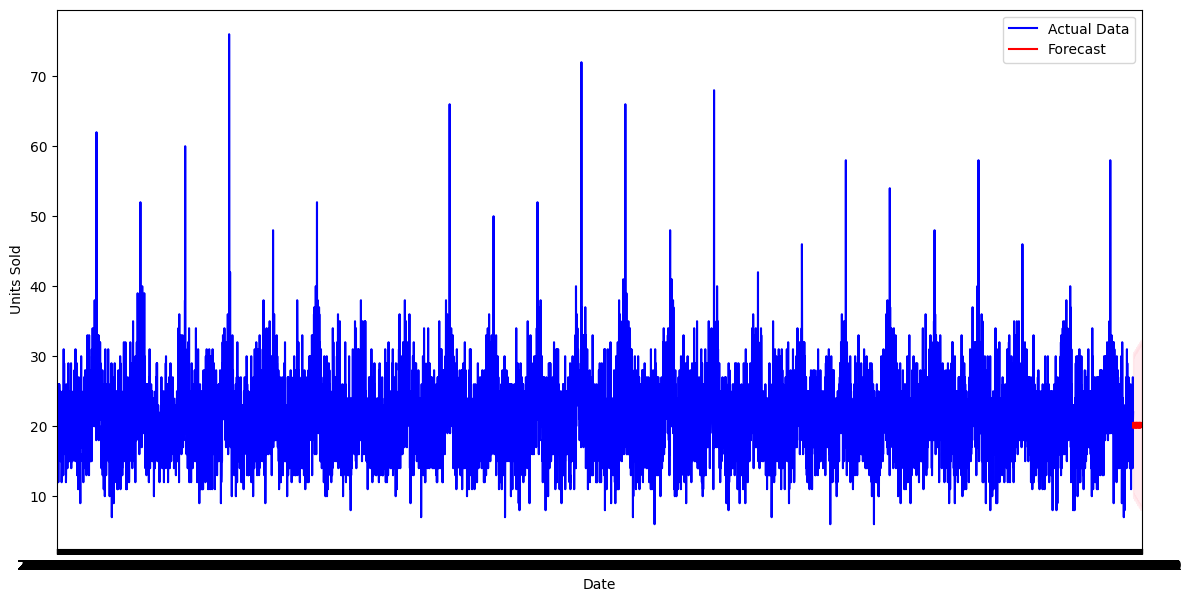

In [78]:
# # Convert the x-axis limits to datetime
start_date = ts_data.index.min()
end_date = pd.to_datetime('2030-05-01')
end_date = end_date.strftime('%Y-%m-%d')
# predicted_conf_plot.index = predicted_conf_plot.index.strftime('%Y-%m-%d')
# Plot the actual data and forecast
plt.figure(figsize=(14, 7))
plt.plot(ts_data.index, ts_data, label='Actual Data', color='blue')
plt.plot(predicted_means.index, predicted_means, label='Forecast', color='red')
plt.fill_between(predicted_conf.index, predicted_conf.iloc[:, 0], predicted_conf.iloc[:, 1], color='pink', alpha=0.3)
# Improve the visibility of x-axis labels
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
plt.xlim([start_date, end_date])
plt.xlabel('Date')
plt.ylabel('Units Sold')
# plt.title('SARIMA Forecast from May 2024 to May 2030')
plt.legend()
plt.show()


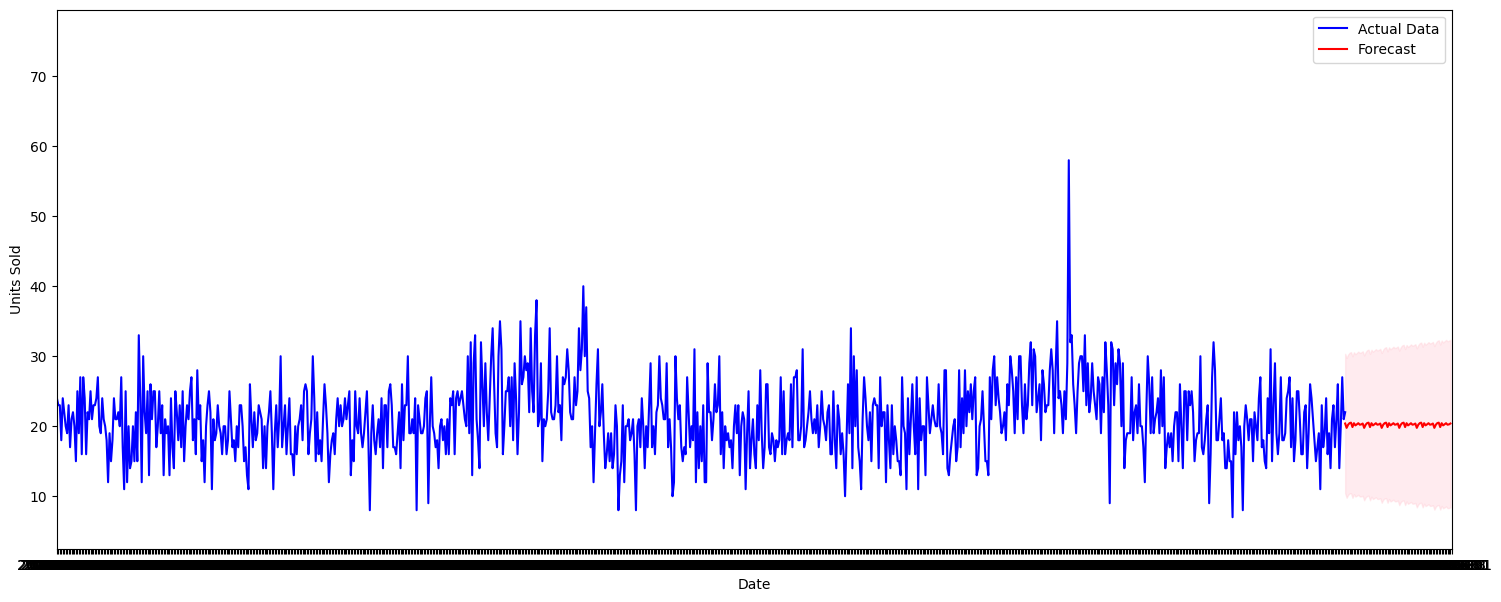

In [89]:
# # Convert the x-axis limits to datetime
# start_date = ts_data.index.min()
start_date = pd.to_datetime('2022-01-01')
start_date = start_date.strftime('%Y-%m-%d')
end_date = pd.to_datetime('2026-05-01')
end_date = end_date.strftime('%Y-%m-%d')
# predicted_conf_plot.index = predicted_conf_plot.index.strftime('%Y-%m-%d')
# Plot the actual data and forecast
plt.figure(figsize=(18, 7))
# # Set up the plot
# fig, ax = plt.subplots(figsize=(18, 7))
plt.plot(ts_data.index, ts_data, label='Actual Data', color='blue')
plt.plot(predicted_means.index, predicted_means, label='Forecast', color='red')
plt.fill_between(predicted_conf.index, predicted_conf.iloc[:, 0], predicted_conf.iloc[:, 1], color='pink', alpha=0.3)

# # Format the x-axis to show only the year
# ax.xaxis.set_major_locator(AutoDateLocator())
# ax.xaxis.set_major_formatter(DateFormatter('%Y'))

# Improve the visibility of x-axis labels
# plt.setp(['2020','2021','2022','2022','2024','2025','2026','2027','2028'], rotation=45, ha='right')
plt.xlim([start_date, end_date])
# Show only specific year intervals on xlim
# plt.set_xticks(pd.date_range(start=start_date, end=end_date, freq='YS'))

plt.xlabel('Date')
plt.ylabel('Units Sold')
# plt.title('SARIMA Forecast from May 2024 to May 2030')
plt.legend()
plt.show()


ConversionError: Failed to convert value(s) to axis units: DatetimeIndex(['2022-12-31', '2023-12-31', '2024-12-31', '2025-12-31'], dtype='datetime64[ns]', freq='A-DEC')

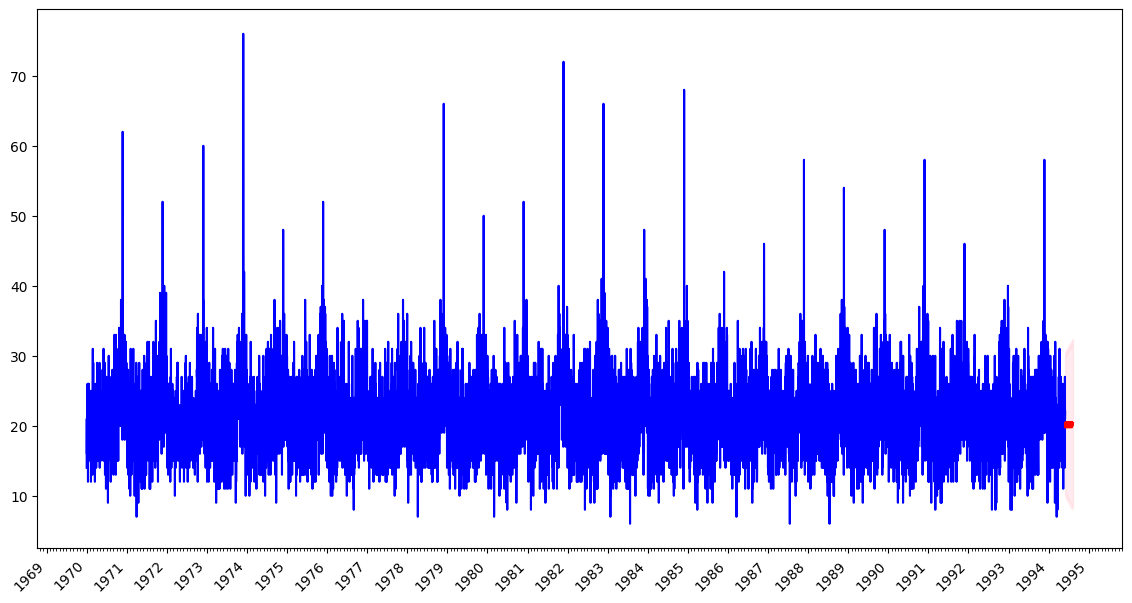

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator, YearLocator

# Assume ts_data and predictions are already calculated

# Convert the x-axis limits to datetime
start_date = pd.to_datetime('2000-01-01')
end_date = pd.to_datetime('2026-05-01')

# Set up the plot
fig, ax = plt.subplots(figsize=(14, 7))

# Plot the actual data and forecast
ax.plot(ts_data.index, ts_data, label='Actual Data', color='blue')
ax.plot(predicted_means.index, predicted_means, label='Forecast', color='red')
ax.fill_between(predicted_conf.index, predicted_conf.iloc[:, 0], predicted_conf.iloc[:, 1], color='pink', alpha=0.3)

# Set major and minor locators and formatters
ax.xaxis.set_major_locator(YearLocator(1))  # Set major ticks to every year
ax.xaxis.set_minor_locator(MonthLocator())  # Set minor ticks to every month
ax.xaxis.set_major_formatter(DateFormatter('%Y'))  # Format major ticks to display the year

# Improve the visibility of x-axis labels
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Explicitly set x-ticks starting from the first year in the data
xticks = pd.date_range(start=start_date, end=end_date, freq='Y')
ax.set_xticks(xticks)

# Ensure the xlim values are datetime objects
plt.xlim([start_date, end_date])

plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.title('SARIMA Forecast from May 2024 to May 2030')
plt.legend()
plt.show()


1. Importing Libraries

python

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import itertools
from google.colab import files
import io
from sklearn.model_selection import TimeSeriesSplit
import unittest
import seaborn as sns
import time

    pandas: Used for data manipulation and analysis.
    numpy: Provides support for large arrays and matrices.
    matplotlib.pyplot: Plotting library for visualizations.
    statsmodels.tsa.statespace.sarimax: Provides SARIMAX model for time series analysis.
    sklearn.metrics: Contains metrics for model evaluation (e.g., mean_squared_error).
    statsmodels.tsa.seasonal: Provides tools for seasonal decomposition.
    statsmodels.tsa.arima.model: Provides ARIMA model for time series analysis.
    Prophet: A forecasting tool by Facebook.
    itertools: Provides tools for creating iterators.
    google.colab: Provides tools for file uploads in Google Colab.
    io: Provides tools for handling file I/O.
    sklearn.model_selection.TimeSeriesSplit: Used for time series cross-validation.
    unittest: Framework for unit testing.
    seaborn: Statistical data visualization library.
    time: Provides time-related functions.

2. Uploading and Loading the Dataset

python

# Step 1: Upload the CSV file
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Step 2: Load the dataset
data = pd.read_csv(io.BytesIO(uploaded[filename]))

    files.upload(): Opens a dialog to upload a file in Google Colab.
    list(uploaded.keys())[0]: Gets the filename of the uploaded file.
    pd.read_csv(io.BytesIO(uploaded[filename])): Reads the uploaded CSV file into a pandas DataFrame.

3. Preprocessing the Data

python

# Step 3: Preprocessing the data
data['Date of Sale'] = pd.to_datetime(data['Date of Sale'], dayfirst=True)
data.set_index('Date of Sale', inplace=True)

# Check for missing values
missing_values = data.isnull().sum()
summary_stats = data.describe()
print(missing_values, summary_stats)

    pd.to_datetime(data['Date of Sale'], dayfirst=True): Converts the 'Date of Sale' column to datetime format, assuming day-first format.
    data.set_index('Date of Sale', inplace=True): Sets 'Date of Sale' as the index of the DataFrame.
    data.isnull().sum(): Checks for missing values in each column.
    data.describe(): Generates summary statistics for the DataFrame.
    print(missing_values, summary_stats): Prints the missing values and summary statistics.

4. Exploratory Data Analysis (EDA)

python

# Step 4: Exploratory Data Analysis (EDA)
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Units Sold'], label='Units Sold')
plt.title('Units Sold Over Time')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.show()

# Check the correlation between 'Units Sold' and economic indicators
correlation_matrix = data[['Units Sold', 'GDP Growth Rate', 'Inflation Rate', 'Price Sold']].corr()
print(correlation_matrix)

    plt.figure(figsize=(12, 6)): Creates a figure for plotting with specified dimensions.
    plt.plot(data.index, data['Units Sold'], label='Units Sold'): Plots 'Units Sold' over time.
    plt.title('Units Sold Over Time'): Sets the title of the plot.
    plt.xlabel('Date'): Sets the x-axis label.
    plt.ylabel('Units Sold'): Sets the y-axis label.
    plt.legend(): Adds a legend to the plot.
    plt.show(): Displays the plot.
    data[['Units Sold', 'GDP Growth Rate', 'Inflation Rate', 'Price Sold']].corr(): Computes the correlation matrix for specified columns.
    print(correlation_matrix): Prints the correlation matrix.

5. Model Development: SARIMA with Cross-Validation

python

# Model Development: SARIMA with Cross-Validation
time_series_data = data['Units Sold']
tscv = TimeSeriesSplit(n_splits=5)

    data['Units Sold']: Extracts the 'Units Sold' column from the DataFrame.
    TimeSeriesSplit(n_splits=5): Initializes a time series cross-validator with 5 splits.

6. Cross-Validation Function

python

# Function to perform cross-validation and find best parameters
def sarima_cross_validation(train_data, param_grid, seasonal_param_grid):
    best_aic = float("inf")
    best_param = None
    best_seasonal_param = None
    
    for param in param_grid:
        for seasonal_param in seasonal_param_grid:
            try:
                temp_aic = 0
                for train_idx, test_idx in tscv.split(train_data):
                    train, test = train_data[train_idx], train_data[test_idx]
                    mod = SARIMAX(train, order=param, seasonal_order=seasonal_param,
                                  enforce_stationarity=False, enforce_invertibility=False,
                                  maxiter=200, method='nm')
                    results = mod.fit(disp=False)
                    temp_aic += results.aic
                temp_aic /= tscv.get_n_splits(train_data)
                if temp_aic < best_aic:
                    best_aic = temp_aic
                    best_param = param
                    best_seasonal_param = seasonal_param
            except:
                continue
                
    return best_param, best_seasonal_param

    best_aic = float("inf"): Initializes the best AIC (Akaike Information Criterion) to infinity.
    best_param, best_seasonal_param = None: Initializes best parameters to None.
    for param in param_grid: Iterates over all combinations of parameters.
    for seasonal_param in seasonal_param_grid: Iterates over all combinations of seasonal parameters.
    try: Attempts to fit the model and compute AIC.
    temp_aic = 0: Initializes temporary AIC to zero.
    for train_idx, test_idx in tscv.split(train_data): Splits the data into training and testing sets.
    train, test = train_data[train_idx], train_data[test_idx]: Extracts training and testing data.
    mod = SARIMAX(...): Initializes the SARIMAX model with specified parameters.
    results = mod.fit(disp=False): Fits the SARIMAX model and suppresses output.
    temp_aic += results.aic: Accumulates the AIC values.
    temp_aic /= tscv.get_n_splits(train_data): Computes the average AIC over the splits.
    if temp_aic < best_aic: Checks if the current AIC is the best so far.
    best_aic = temp_aic: Updates the best AIC.
    best_param = param: Updates the best parameter set.
    best_seasonal_param = seasonal_param: Updates the best seasonal parameter set.
    except: Handles any exceptions during the fitting process.

7. Define Parameter Grids

python

# Define parameter grids
p = d = q = range(0, 2)  # Simplified parameter range
param_grid = list(itertools.product(p, d, q))
seasonal_param_grid = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    p = d = q = range(0, 2): Defines the range of parameters (0 or 1) for p, d, and q.
    param_grid = list(itertools.product(p, d, q)): Creates a grid of parameter combinations.
    seasonal_param_grid = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]: Creates a grid of seasonal parameter combinations with a periodicity of 12.

8. Perform Cross-Validation

python

# Perform cross-validation to find best parameters
best_param, best_seasonal_param = sarima_cross_validation(time_series_data.values, param_grid, seasonal_param_grid)
print(f'Best SARIMA parameters: {best_param}, Seasonal: {best_seasonal_param}')

    sarima_cross_validation(time_series_data.values, param_grid, seasonal_param_grid): Calls the cross-validation function with the data and parameter grids.
    print(f'Best SARIMA parameters: {best_param}, Seasonal: {best_seasonal_param}'): Prints the best parameters found.

    9. Fit SARIMA Model (Continued)

python

# Fit SARIMA model on the entire dataset
sarima_model = SARIMAX(time_series_data, order=best_param, seasonal_order=best_seasonal_param,
                       enforce_stationarity=False, enforce_invertibility=False,
                       maxiter=200, method='nm')
sarima_results = sarima_model.fit(disp=False)

    SARIMAX(time_series_data, ...): Initializes the SARIMAX model with the best parameters found during cross-validation.
    order=best_param: Sets the non-seasonal order parameters (p, d, q).
    seasonal_order=best_seasonal_param: Sets the seasonal order parameters (P, D, Q, s).
    enforce_stationarity=False: Allows the model to fit non-stationary data.
    enforce_invertibility=False: Allows the model to fit non-invertible data.
    maxiter=200: Sets the maximum number of iterations for the optimizer.
    method='nm': Uses the Nelder-Mead optimization method.
    sarima_results = sarima_model.fit(disp=False): Fits the SARIMAX model and suppresses output.

10. Forecasting with SARIMA

python

# Predict future sales using SARIMA
forecast_steps = 12
sarima_forecast = sarima_results.get_forecast(steps=forecast_steps)
predicted_means = sarima_forecast.predicted_mean

    forecast_steps = 12: Defines the number of steps (months) to forecast.
    sarima_results.get_forecast(steps=forecast_steps): Generates forecast for the specified number of steps.
    predicted_means = sarima_forecast.predicted_mean: Extracts the predicted mean values from the forecast.

11. Plotting the Forecast

python

# Plot SARIMA forecast
plt.figure(figsize=(12, 6))
plt.plot(time_series_data.index, time_series_data, label='Observed')
plt.plot(pd.date_range(start=time_series_data.index[-1], periods=forecast_steps+1, freq='M')[1:], predicted_means, label='Forecast', color='red')
plt.fill_between(predicted_means.index, sarima_forecast.conf_int().iloc[:, 0],
                 sarima_forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.show()

    plt.figure(figsize=(12, 6)): Creates a figure for plotting with specified dimensions.
    plt.plot(time_series_data.index, time_series_data, label='Observed'): Plots the observed data.
    plt.plot(pd.date_range(start=time_series_data.index[-1], periods=forecast_steps+1, freq='M')[1:], predicted_means, label='Forecast', color='red'): Plots the forecasted values.
    plt.fill_between(predicted_means.index, ...): Adds a confidence interval shading to the plot.
    plt.title('SARIMA Forecast'): Sets the title of the plot.
    plt.xlabel('Date'): Sets the x-axis label.
    plt.ylabel('Units Sold'): Sets the y-axis label.
    plt.legend(): Adds a legend to the plot.
    plt.show(): Displays the plot.

12. Seasonal Decomposition

python

# Seasonal Decomposition
result = seasonal_decompose(time_series_data, model='additive', period=12)
result.plot()
plt.show()

    seasonal_decompose(time_series_data, model='additive', period=12): Decomposes the time series into trend, seasonal, and residual components with an additive model.
    result.plot(): Plots the decomposed components.
    plt.show(): Displays the plot.

13. ARIMA Model

python

# ARIMA Model
arima_model = ARIMA(time_series_data, order=best_param)
arima_results = arima_model.fit()
arima_forecast = arima_results.forecast(steps=forecast_steps)
arima_rmse = np.sqrt(mean_squared_error(time_series_data[-forecast_steps:], arima_forecast))
print(f'ARIMA RMSE: {arima_rmse}')

    ARIMA(time_series_data, order=best_param): Initializes the ARIMA model with the best parameters found during cross-validation.
    arima_results = arima_model.fit(): Fits the ARIMA model.
    arima_forecast = arima_results.forecast(steps=forecast_steps): Generates forecast for the specified number of steps.
    arima_rmse = np.sqrt(mean_squared_error(time_series_data[-forecast_steps:], arima_forecast)): Calculates the RMSE for the ARIMA model.
    print(f'ARIMA RMSE: {arima_rmse}'): Prints the RMSE for the ARIMA model.

14. Prophet Model

python

# Prophet Model
prophet_data = time_series_data.reset_index()
prophet_data.columns = ['ds', 'y']

prophet_model = Prophet()
prophet_model.fit(prophet_data)

future = prophet_model.make_future_dataframe(periods=forecast_steps, freq='M')
forecast = prophet_model.predict(future)
prophet_forecast = forecast['yhat'][-forecast_steps:]
prophet_rmse = np.sqrt(mean_squared_error(prophet_data['y'][-forecast_steps:], prophet_forecast))
print(f'Prophet RMSE: {prophet_rmse}')

# Plot forecast
prophet_model.plot(forecast)
plt.show()

    prophet_data = time_series_data.reset_index(): Resets the index of the time series data for Prophet.
    prophet_data.columns = ['ds', 'y']: Renames the columns for Prophet (ds = date, y = value).
    Prophet(): Initializes the Prophet model.
    prophet_model.fit(prophet_data): Fits the Prophet model.
    future = prophet_model.make_future_dataframe(periods=forecast_steps, freq='M'): Creates a future DataFrame for forecasting.
    forecast = prophet_model.predict(future): Generates forecast.
    prophet_forecast = forecast['yhat'][-forecast_steps:]: Extracts the forecasted values.
    prophet_rmse = np.sqrt(mean_squared_error(prophet_data['y'][-forecast_steps:], prophet_forecast)): Calculates the RMSE for the Prophet model.
    print(f'Prophet RMSE: {prophet_rmse}'): Prints the RMSE for the Prophet model.
    prophet_model.plot(forecast): Plots the forecast.
    plt.show(): Displays the plot.

15. Generating Inventory Report

python

# Step 6: Generate Inventory Report
def generate_inventory_report(data):
    report = {}
    
    # Calculate key metrics
    report['Total Units Sold'] = data['Units Sold'].sum()
    report['Average Units Sold per Day'] = data['Units Sold'].mean()
    report['Inventory Turnover Ratio'] = data['Units Sold'].sum() / data['Units Sold'].mean()
    report['Days of Supply'] = data['Units Sold'].mean() / data['Units Sold'].sum() * 365
    report['Stockout Rates'] = (data['Units Sold'] == 0).sum() / len(data) * 100
    
    # Generate summary statistics
    summary_stats = data.describe()
    
    # Generate visualizations
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Units Sold'], label='Units Sold')
    plt.title('Units Sold Over Time')
    plt.xlabel('Date')
    plt.ylabel('Units Sold')
    plt.legend()
    plt.show()
    
    return report, summary_stats

# Generate the report
inventory_report, summary_stats = generate_inventory_report(data)
print(inventory_report)
print(summary_stats)

    generate_inventory_report(data): Defines a function to generate an inventory report.
    report = {}: Initializes an empty dictionary to store report metrics.
    report['Total Units Sold'] = data['Units Sold'].sum(): Calculates the total units sold.
    report['Average Units Sold per Day'] = data['Units Sold'].mean(): Calculates the average units sold per day.
    report['Inventory Turnover Ratio'] = data['Units Sold'].sum() / data['Units Sold'].mean(): Calculates the inventory turnover ratio.
    report['Days of Supply'] = data['Units Sold'].mean() / data['Units Sold'].sum() * 365: Calculates the days of supply.
    report['Stockout Rates'] = (data['Units Sold'] == 0).sum() / len(data) * 100: Calculates the stockout rates.
    summary_stats = data.describe(): Generates summary statistics.
    plt.figure(figsize=(12, 6)): Creates a figure for plotting with specified dimensions.
    plt.plot(data.index, data['Units Sold'], label='Units Sold'): Plots 'Units Sold' over time.
    plt.title('Units Sold Over Time'): Sets the title of the plot.
    plt.xlabel('Date'): Sets the x-axis label.
    plt.ylabel('Units Sold'): Sets the y-axis label.